In [1]:
# Some standard imports
import io
import numpy as np
import torch

from torch import nn
import torch.utils.model_zoo as model_zoo

# Super Resolution model definition in PyTorch
import torch.nn as nn
import torch.nn.init as init

# Import custom library for kernel transformations
import upsampling.layers as L

In [2]:
# The model `<https://github.com/pytorch/examples/blob/master/super_resolution/model.py>`
# comes directly from PyTorch's examples with a minor modification to fuse convolution and 
# pixel shuffle operations into a deconvolution.

class SuperResolutionNet(nn.Module):
    def __init__(self, upscale_factor, inplace=False):
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        
        # This is the original forward pass
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        # We are replacing conv4 + pixel_shuffle with this. However, because
        # we are loading the weights from the PyTorch example, we initialize
        # this later using Weight Shuffle (and bias shuffle)
        self.deconv_layer = None
        self.deconv_bias = None
        self._deconv_pass = False

        self._initialize_weights()

    def transform_convolution_to_deconvolution(self):
        # Deconvolution operation - note that PyTorch uses STRD as a back-end
        self.deconv_layer = torch.nn.ConvTranspose2d(
            in_channels   = self.conv4.in_channels,
            out_channels  = self.conv4.out_channels // pow(self.pixel_shuffle.upscale_factor, 2),
            kernel_size   = self.conv4.kernel_size[0] * self.pixel_shuffle.upscale_factor,
            stride        = self.pixel_shuffle.upscale_factor,
            padding       = self.conv4.padding[0] * self.pixel_shuffle.upscale_factor,
            bias          = False)

        # Shuffle convolution weights to be equivalent to the deconvolution
        weight_shuff  = L.WeightShuffle(self.pixel_shuffle.upscale_factor)
        self.deconv_layer.weight.data = weight_shuff(self.conv4.weight)
        
        # Shuffle the convolution biases to be equivalent to the deconvolution
        self.deconv_bias = L.bias_shuffle(self.conv4.bias, self.pixel_shuffle.upscale_factor, 
                           x.shape[2], x.shape[3])
        # Set the deconvolution pass to True
        self._deconv_pass = True
        
    def deconvolution(self, x:torch.Tensor) -> torch.Tensor:
        assert self._deconv_pass, "Make sure to transform convolution to deconvolution"
        print("Using deconvolution path")
        h = self.deconv_layer(x)
        return h + self.deconv_bias

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x)) if not self._deconv_pass else self.deconvolution(x)
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

In [3]:
import os, pathlib
from PIL import Image
from torchvision.transforms import ToTensor

def process_input_image(image_path:str) -> torch.Tensor:
    # From <https://github.com/pytorch/examples/blob/master/super_resolution/super_resolve.py>
    img = Image.open(image_path).convert('YCbCr')
    y, cb, cr = img.split()
    img_to_tensor = ToTensor()
    return img_to_tensor(y).view(1, -1, y.size[1], y.size[0]), cb, cr

def process_output_image(out:torch.Tensor, cb:np.ndarray, cr:np.ndarray) -> Image:
    # From <https://github.com/pytorch/examples/blob/master/super_resolution/super_resolve.py>
    out = out.cpu()
    out_img_y = out[0].detach().numpy()
    out_img_y *= 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

    out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
    return Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')

In [4]:
# Create the super-resolution model by using the above model definition.
model = SuperResolutionNet(upscale_factor=3)

# Load pretrained model weights
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'
batch_size = 1

# Initialize model with the pretrained weights
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))

<All keys matched successfully>

output image saved to  static/baseline.jpg


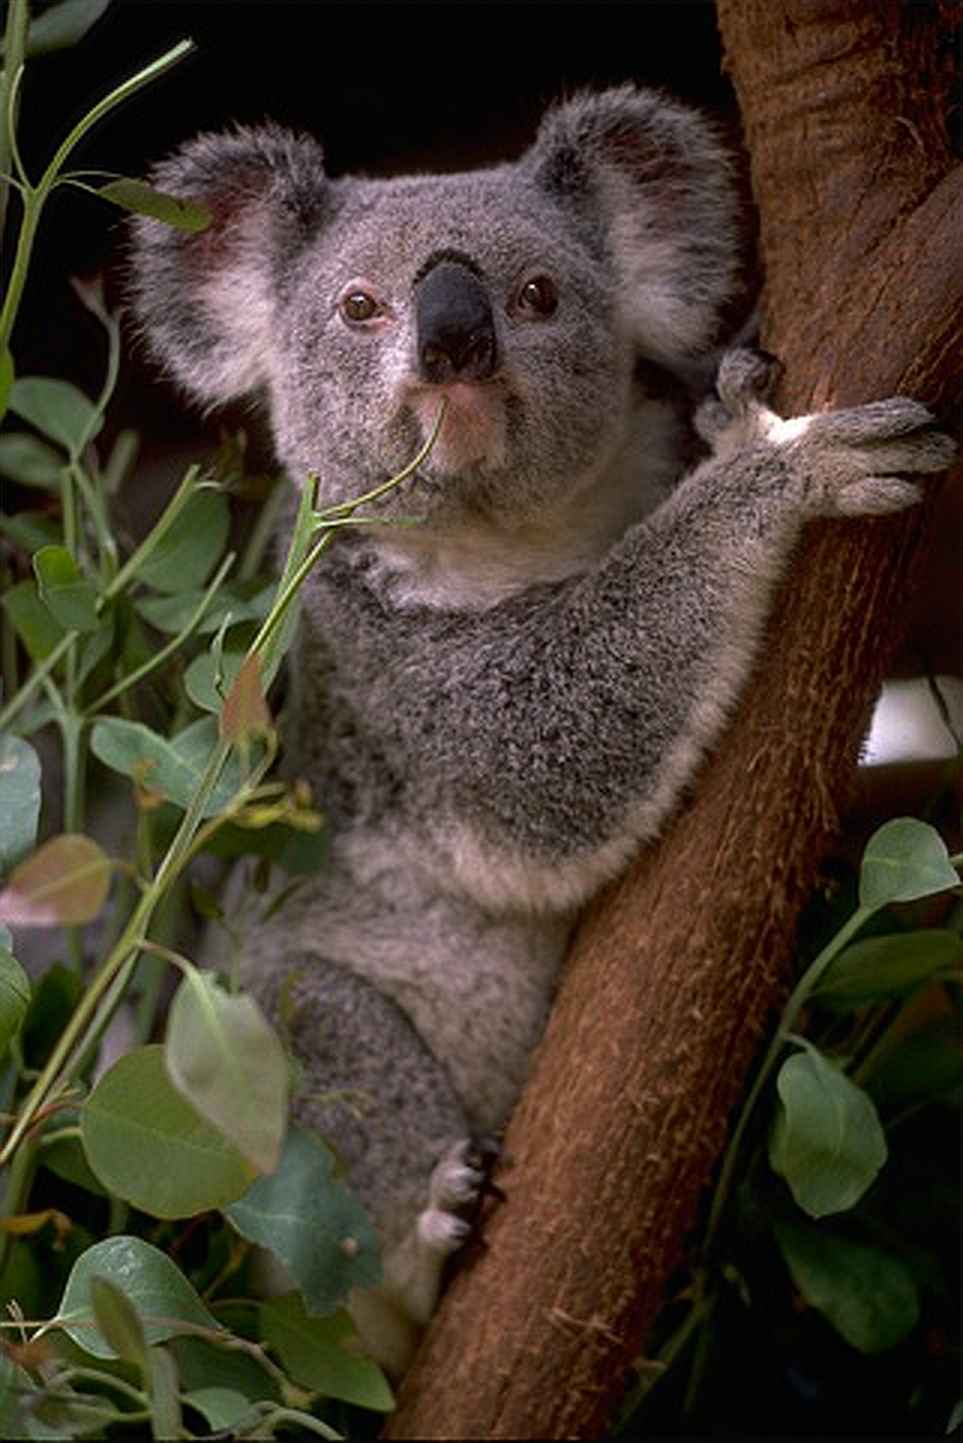

In [5]:
# A test image from the BSD300 super resolution dataset using the convolution + pixel shuffle path
output_path = "static/baseline.jpg"

x, cb, cr = process_input_image("static/koala.jpg")

y_baseline = model(x)

y_baseline = process_output_image(y_baseline, cb, cr)
y_baseline.save(output_path)
print('output image saved to ', output_path)
y_baseline

Using deconvolution path
output image saved to  static/deconvolution.jpg


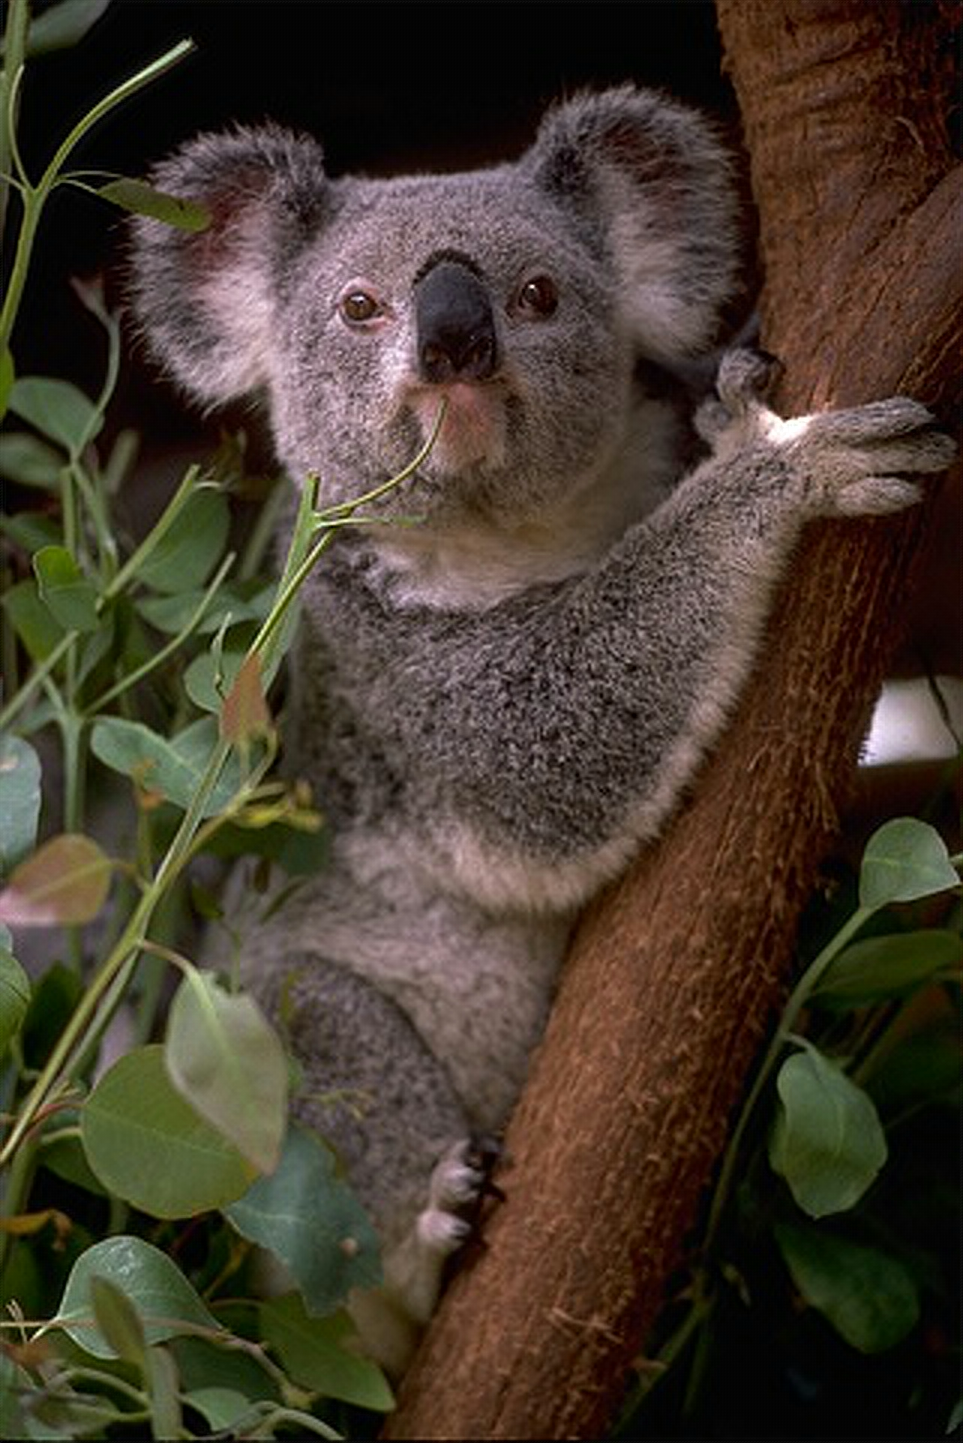

In [6]:
# A test image from the BSD300 super resolution dataset using the deconvolution path
output_path = "static/deconvolution.jpg"

model.transform_convolution_to_deconvolution()

y_deconv = model(x)

y_deconv = process_output_image(y_deconv, cb, cr)
y_deconv.save(output_path)
print('output image saved to ', output_path)
y_deconv

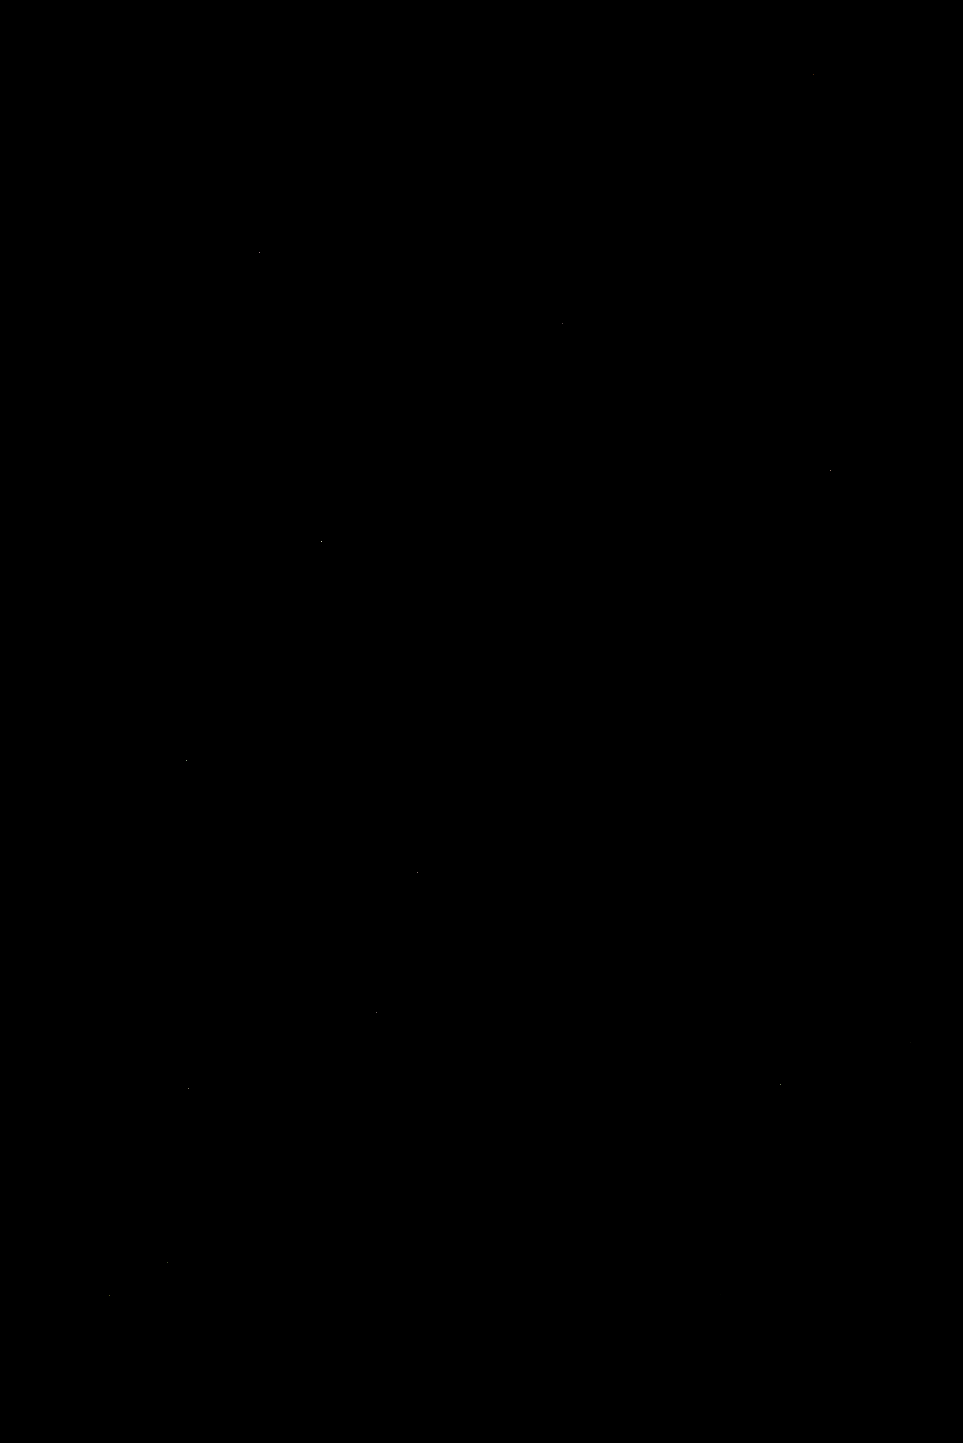

In [7]:
from PIL import ImageChops

point_table = ([0] + ([255] * 255))

def black_or_b(a, b):
    diff = ImageChops.difference(a, b)
    diff = diff.convert('L')
    diff = diff.point(point_table)
    new = diff.convert('RGB')
    new.paste(b, mask=diff)
    return new


c = black_or_b(y_deconv, y_baseline)
c.save('static/image_difference.png')
c